In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import minimize

# Exponential decay to 0 

In [8]:
time = np.linspace(0,10)

def sun(t):
    return 10 + np.sin(t)

def x_a_0(t):
    return sun(t) * np.exp(-0.04*t)

def x_b_0(t):
    return sun(t) * np.exp(-0.04*t/4)

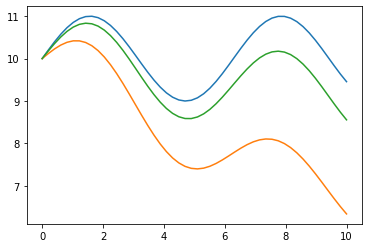

In [9]:
plt.plot(time, sun(time), time, x_a_0(time), time, x_b_0(time))

# Exponential decay to 1/2

In [77]:
time = np.linspace(0,10)

lam = 0.5
x0 = np.log(1/2)/lam


def sun(t):
    return 10 + np.sin(t)

def x_a_0(t):
    return sun(t) * (1 - np.exp(lam*x0) + np.exp(-lam*(t-x0)))

def x_b_0(t):
    return sun(t) * (1 - np.exp(lam*x0) + np.exp(-lam*(t/4-x0)))



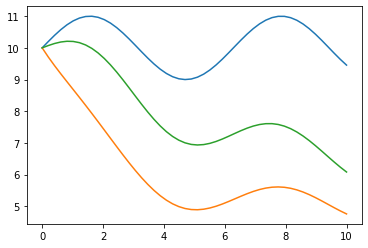

In [78]:
plt.plot(time, sun(time), time, x_a_0(time), time, x_b_0(time))

# Exponential + linear decay

In [3]:
time = np.linspace(0,10)

lam = 0.5
x0 = np.log(1/2)/lam
alpha = 0.03

def sun(t):
    return 10 + np.sin(t)

def x_a_0(t):
    return sun(t) * (1 - np.exp(lam*x0) + np.exp(-lam*(t-x0)) - alpha * t)

def x_b_0(t):
    return sun(t) * (1 - np.exp(lam*x0) + np.exp(-lam*(t/4-x0)) - alpha * t/4)


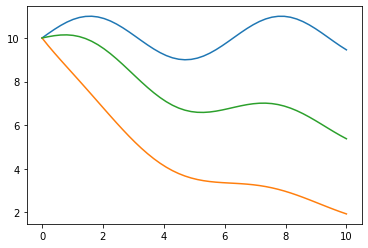

In [4]:
plt.plot(time, sun(time), time, x_a_0(time), time, x_b_0(time))

# Simulation for convergence

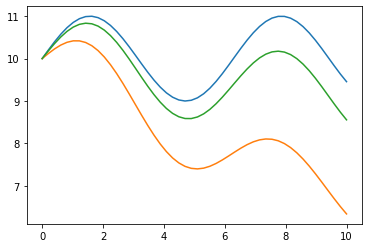

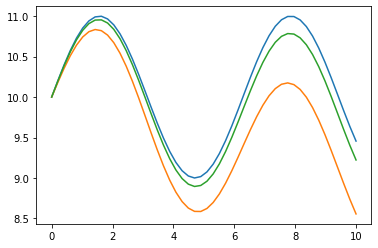

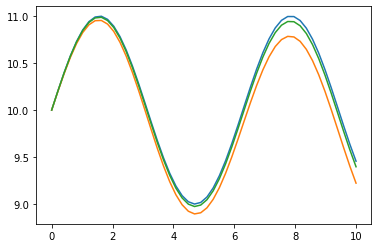

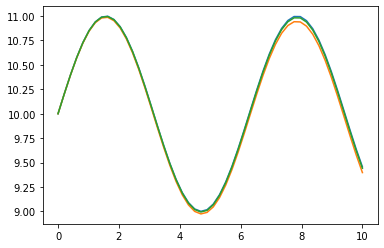

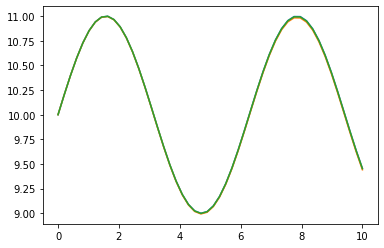

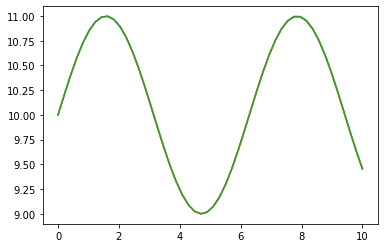

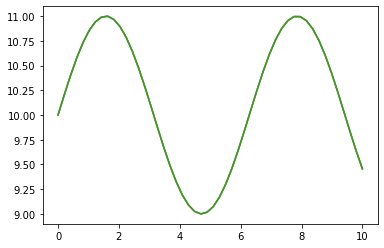

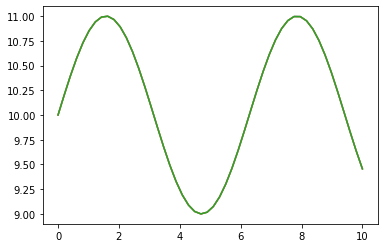

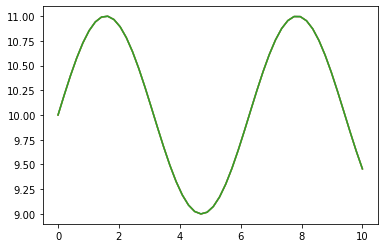

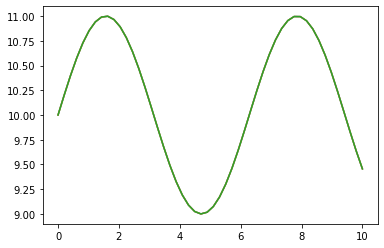

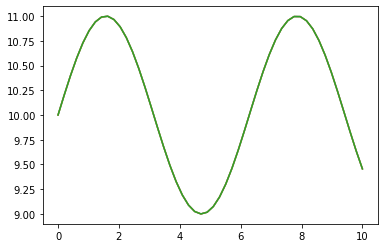

In [13]:
ratio_s = """
def ratio_{0}(t):
    return x_a_{0}(t) / x_b_{0}(t)
"""

x_a_s = """
def x_a_{1}(t):
    return  x_a_{0}(t) / ratio_{0}(t)
"""

x_b_s = """
def x_b_{1}(t):
    return  x_b_{0}(t) / ratio_{0}(t/4)
"""

plt.plot(time, sun(time), time, x_a_0(time), time, x_b_0(time))
plt.show()

for i in range(10):
    exec(ratio_s.format(i))
    exec(x_a_s.format(i, i+1))
    exec(x_b_s.format(i, i+1))

    exec("plt.plot(time, sun(time), time, x_a_{0}(time), time, x_b_{0}(time))".format(i+1))
    plt.show()

# Simulated real life example

In [5]:
class DegradationSpline():
    def __init__(self, k=3, s_params=(-14,0), steps=30):
        self.k = k
        self.s_params = self._s_param_generator(*s_params)
        self.steps = steps

    def _s_param_generator(self, start, finish):
        for i in range(start, finish):
            for j in range(1, 10):
                yield j * 10 ** i

    def _guess(self, x, y, k, s, w=None):
        """Do an ordinary spline fit to provide knots"""
        return splrep(x, y, w, k=k, s=s)

    def _err(self, c, x, y, t, k, w=None):
        """The error function to minimize"""
        diff = y - splev(x, (t, c, k))
        if w is None:
            diff = np.einsum('...i,...i', diff, diff)
        else:
            diff = np.dot(diff * diff, w)
        return np.abs(diff)

    def _spline_dirichlet(self, x, y, k=3, s=0, w=None):
        t, c0, k = self._guess(x, y, k, s, w=w)
        x0 = x[0]  # point at which 1 is required
        xl = x[-1]
        con = {'type': 'eq',
               'fun': lambda c: splev(x0, (t, c, k), der=0) - 1,
               }
        opt = minimize(self._err, c0, (x, y, t, k, w), constraints=con)
        copt = opt.x
        return UnivariateSpline._from_tck((t, copt, k))

    def _is_decreasing(self, spline, x):
        spline_derivative = spline.derivative()
        return np.all(spline_derivative(x.ravel()) < 0)

    def _is_convex(self, spline, x):
        spline_derivative_2 = spline.derivative().derivative()
        return np.all(spline_derivative_2(x.ravel()) > 0)

    def _find_convex_decreasing_spline(self, x, y):
        for s in self.s_params:
            spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
            if self._is_decreasing(spline, x) and self._is_convex(spline, x):
                return spline
        raise Exception(
            'Could not find increasng and convex spline for this set of sensitivity parameters and fitting data x, y')

    def _find_convex_decreasing_spline_binary_seach(self, x, y):
        """
        for start it should be weird
        for end it should be decreasing
        """
        start = 0
        end = 1
        mid = (end - start) / 2
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
        step = 1
        while step <= self.steps:
            if self._is_decreasing(spline, x):
                end = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            else:
                start = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            step += 1
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=end)
        if not self._is_convex(spline, x):
            warnings.warn("Spline is decrasing but not convex.")
        return spline
    
    def test(self, x, y, s):
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
        print(self._is_decreasing(spline, x))
        print(self._is_convex(spline, x))
        return spline(x)
                
    def fit(self, x, y):
        self.sp = self._find_convex_decreasing_spline_binary_seach(x, y)

    def predict(self, x):
        return self.sp(x)

## Setup of the signals

In [6]:
time = np.linspace(0,10, num=100)

lam = 0.5
x0 = np.log(1/2)/lam
alpha = 0.03
epsilon = 0.3

sun = 10 + np.sin(time) 
x_a_0 = sun * (1 - np.exp(lam*x0) + np.exp(-lam*(time-x0)) - alpha * time) + epsilon * np.random.rand(len(time))
x_b_0 = sun * (1 - np.exp(lam*x0) + np.exp(-lam*(time/4-x0)) - alpha * time/4) + epsilon * np.random.rand(len(time))

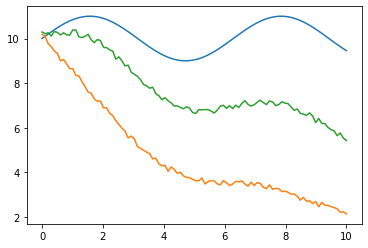

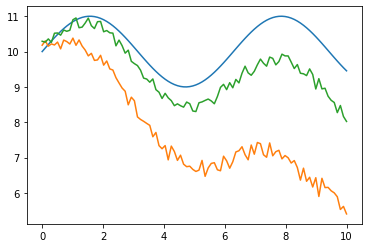

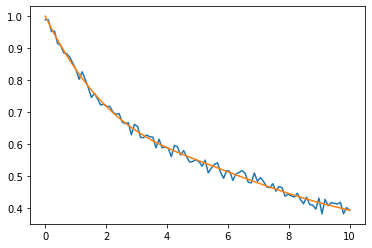

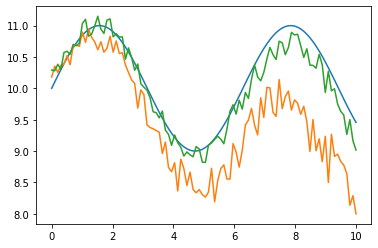

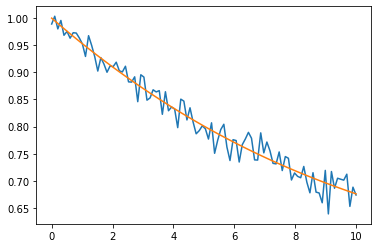

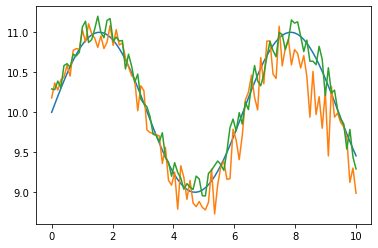

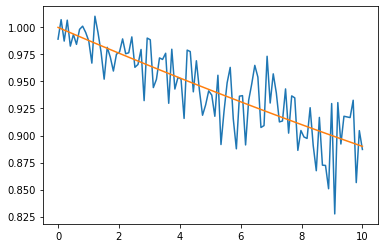

/Users/lenarttreven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Spline is decrasing but not convex.


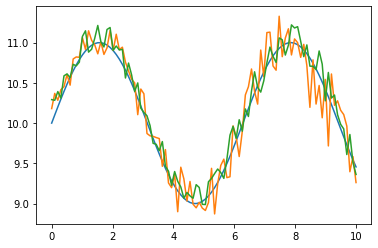

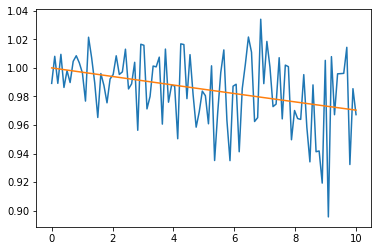

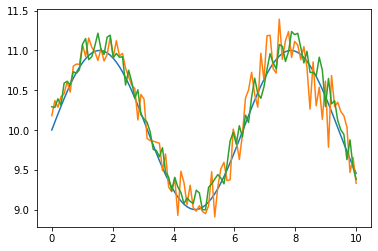

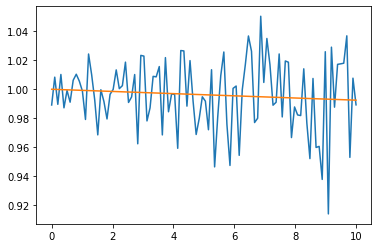

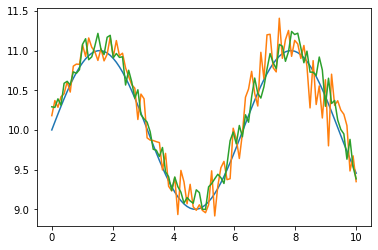

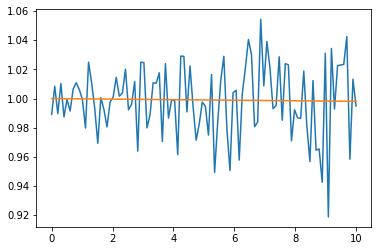

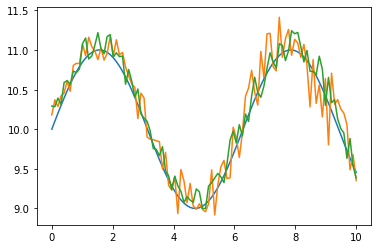

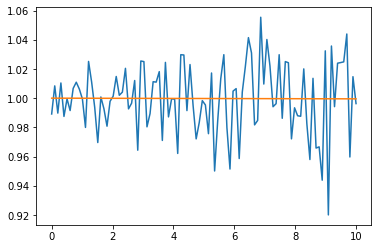

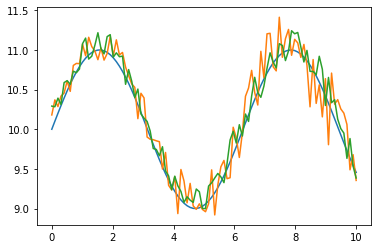

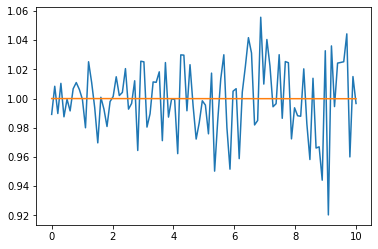

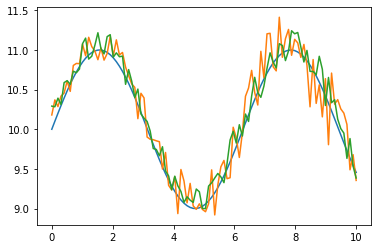

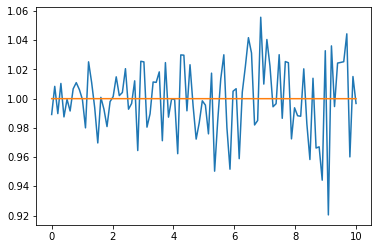

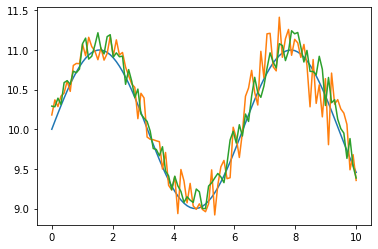

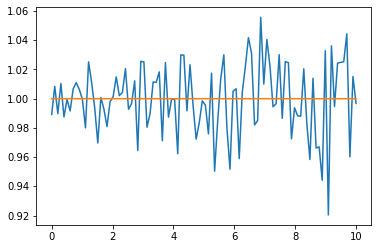

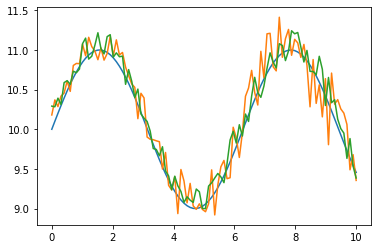

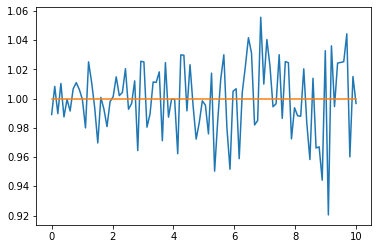

In [7]:
step = 0
plt.plot(time, sun, time, x_a_0, time, x_b_0)
plt.show()
while step <= 10:
    r = x_a_0/x_b_0
    model = DegradationSpline()
    model.fit(time, r)
    x_a_0 = x_a_0/model.predict(time)
    x_b_0 = x_b_0/model.predict(time/4)
    plt.plot(time, sun, time, x_a_0, time, x_b_0)
    plt.show()
    plt.plot(time, r, time, model.predict(time))
    plt.show()
    step +=1